In [ ]:
# https://github.com/lsh1994/keras-segmentation
! gdown https://drive.google.com/u/0/uc?id=0B0d9ZiqAgFkiOHR1NTJhWVJMNEU

Downloading...
From: https://drive.google.com/u/0/uc?id=0B0d9ZiqAgFkiOHR1NTJhWVJMNEU
To: /content/dataset1.zip
126MB [00:01, 74.9MB/s]


In [ ]:
! unzip -qq dataset1.zip

In [73]:
! mkdir results

In [72]:
# ! rm -rf results

In [ ]:
len(glob.glob('/content/dataset1/images_prepped_test/*'))

101

In [ ]:
# LoadBatches.py

import numpy as np
import cv2
import glob
import itertools
import matplotlib.pyplot as plt
import random


def getImageArr(im):

    img = im.astype(np.float32)

    img[:, :, 0] -= 103.939
    img[:, :, 1] -= 116.779
    img[:, :, 2] -= 123.68

    return img


def getSegmentationArr(seg, nClasses, input_height, input_width):

    seg_labels = np.zeros((input_height, input_width, nClasses))

    for c in range(nClasses):
        seg_labels[:, :, c] = (seg == c).astype(int)

    seg_labels = np.reshape(seg_labels, (-1, nClasses))
    return seg_labels


def imageSegmentationGeneratorLB(images_path, segs_path, batch_size,
                               n_classes, input_height, input_width):

    assert images_path[-1] == '/'
    assert segs_path[-1] == '/'

    images = sorted(glob.glob(images_path + "*.jpg") +
                    glob.glob(images_path + "*.png") + glob.glob(images_path + "*.jpeg"))

    segmentations = sorted(glob.glob(segs_path + "*.jpg") +
                           glob.glob(segs_path + "*.png") + glob.glob(segs_path + "*.jpeg"))

    zipped = itertools.cycle(zip(images, segmentations))

    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            im, seg = zipped.__next__()
            im = cv2.imread(im, 1)
            seg = cv2.imread(seg, 0)

            assert im.shape[:2] == seg.shape[:2]

            assert im.shape[0] >= input_height and im.shape[1] >= input_width

            xx = random.randint(0, im.shape[0] - input_height)
            yy = random.randint(0, im.shape[1] - input_width)

            im = im[xx:xx + input_height, yy:yy + input_width]
            seg = seg[xx:xx + input_height, yy:yy + input_width]

            X.append(getImageArr(im))
            Y.append(
                getSegmentationArr(
                    seg,
                    n_classes,
                    input_height,
                    input_width))

        yield np.array(X), np.array(Y)

[ 0  1  2  3  4  5  6  8  9 11]


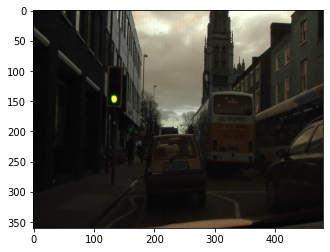

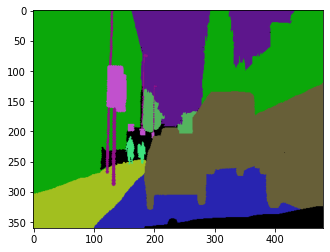

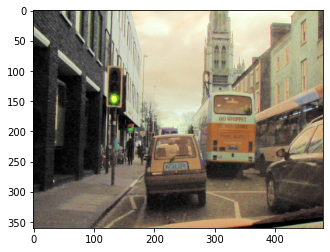

In [ ]:
# visualizeDataset.py

import glob
import numpy as np
import cv2
import random
from skimage import color, exposure
from google.colab.patches import cv2_imshow

def imageSegmentationGenerator(images_path, segs_path, n_classes):

    assert images_path[-1] == '/'
    assert segs_path[-1] == '/'

    images = sorted(
        glob.glob(
            images_path +
            "*.jpg") +
        glob.glob(
            images_path +
            "*.png") +
        glob.glob(
            images_path +
            "*.jpeg"))
    segmentations = sorted(glob.glob(
        segs_path + "*.jpg") + glob.glob(segs_path + "*.png") + glob.glob(segs_path + "*.jpeg"))

    colors = [
        (random.randint(
            0, 255), random.randint(
            0, 255), random.randint(
                0, 255)) for _ in range(n_classes)]

    assert len(images) == len(segmentations)

    for im_fn, seg_fn in zip(images, segmentations):

        img = cv2.imread(im_fn)
        seg = cv2.imread(seg_fn)
        print(np.unique(seg))

        seg_img = np.zeros_like(seg)

        for c in range(n_classes):
            seg_img[:, :, 0] += ((seg[:, :, 0] == c) *
                                 (colors[c][0])).astype('uint8')
            seg_img[:, :, 1] += ((seg[:, :, 0] == c) *
                                 (colors[c][1])).astype('uint8')
            seg_img[:, :, 2] += ((seg[:, :, 0] == c) *
                                 (colors[c][2])).astype('uint8')

        eqaimg = color.rgb2hsv(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        eqaimg[:, :, 2] = exposure.equalize_hist(eqaimg[:, :, 2])
        eqaimg = color.hsv2rgb(eqaimg)

        # image
        plt.imshow(img)
        plt.show()
        # mask
        plt.imshow(seg_img)
        plt.show()
        # equalize_hist_img
        plt.imshow(
            cv2.cvtColor(
                (eqaimg *
                 255.).astype(
                    np.uint8),
                cv2.COLOR_RGB2BGR))
        plt.show()
        #cv2.waitKey()
        break


images = "dataset1/images_prepped_train/"
annotations = "dataset1/annotations_prepped_train/"
n_classes = 11

imageSegmentationGenerator(images, annotations, n_classes)

In [ ]:
# Models/FCN8.py

from keras.applications import vgg16
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, Input, Cropping2D, add, Dropout, Reshape, Activation


def FCN8_helper(nClasses, input_height, input_width):

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    img_input = Input(shape=(input_height, input_width, 3))

    model = vgg16.VGG16(
        include_top=False,
        weights='imagenet', input_tensor=img_input,
        pooling=None,
        classes=1000)
    assert isinstance(model, Model)

    o = Conv2D(
        filters=4096,
        kernel_size=(
            7,
            7),
        padding="same",
        activation="relu",
        name="fc6")(
            model.output)
    o = Dropout(rate=0.5)(o)
    o = Conv2D(
        filters=4096,
        kernel_size=(
            1,
            1),
        padding="same",
        activation="relu",
        name="fc7")(o)
    o = Dropout(rate=0.5)(o)

    o = Conv2D(filters=nClasses, kernel_size=(1, 1), padding="same", activation="relu", kernel_initializer="he_normal",
               name="score_fr")(o)

    o = Conv2DTranspose(filters=nClasses, kernel_size=(2, 2), strides=(2, 2), padding="valid", activation=None,
                        name="score2")(o)

    fcn8 = Model(inputs=img_input, outputs=o)
    # mymodel.summary()
    return fcn8


def FCN8(nClasses, input_height, input_width):

    fcn8 = FCN8_helper(nClasses, input_height, input_width)

    # Conv to be applied on Pool4
    skip_con1 = Conv2D(nClasses, kernel_size=(1, 1), padding="same", activation=None, kernel_initializer="he_normal",
                       name="score_pool4")(fcn8.get_layer("block4_pool").output)
    Summed = add(inputs=[skip_con1, fcn8.output])

    x = Conv2DTranspose(nClasses, kernel_size=(2, 2), strides=(2, 2), padding="valid", activation=None,
                        name="score4")(Summed)

    ###
    skip_con2 = Conv2D(nClasses, kernel_size=(1, 1), padding="same", activation=None, kernel_initializer="he_normal",
                       name="score_pool3")(fcn8.get_layer("block3_pool").output)
    Summed2 = add(inputs=[skip_con2, x])

    #####
    Up = Conv2DTranspose(nClasses, kernel_size=(8, 8), strides=(8, 8),
                         padding="valid", activation=None, name="upsample")(Summed2)

    Up = Reshape((-1, nClasses))(Up)
    Up = Activation("softmax")(Up)

    mymodel = Model(inputs=fcn8.input, outputs=Up)

    return mymodel


In [ ]:
# Models/SegNet.py

"""
@author: LiShiHang
@software: PyCharm
@file: SegNet.py
@time: 2018/12/18 14:58
"""
from keras import Model,layers
from keras.layers import Input,Conv2D,BatchNormalization,Activation,Reshape

from Models.utils import MaxUnpooling2D,MaxPoolingWithArgmax2D

def SegNet(nClasses, input_height, input_width):

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    img_input = Input(shape=( input_height, input_width,3))

    # Block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(img_input)
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    x, mask_1 = MaxPoolingWithArgmax2D(name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x , mask_2 = MaxPoolingWithArgmax2D(name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2')(x)
    x = layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3')(x)
    x, mask_3 = MaxPoolingWithArgmax2D(name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3')(x)

    x, mask_4 = MaxPoolingWithArgmax2D(name='block4_pool')(x)

    # Block 5
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2')(x)
    x = layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3')(x)
    x, mask_5 = MaxPoolingWithArgmax2D(name='block5_pool')(x)

    Vgg_streamlined=Model(inputs=img_input,outputs=x)

    # 加载vgg16的预训练权重
    Vgg_streamlined.load_weights(r"E:\Code\PycharmProjects\keras-segmentation\data\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

    # 解码层
    unpool_1 = MaxUnpooling2D()([x, mask_5])
    y = Conv2D(512, (3,3), padding="same")(unpool_1)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)
    y = Conv2D(512, (3, 3), padding="same")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)
    y = Conv2D(512, (3, 3), padding="same")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    unpool_2 = MaxUnpooling2D()([y, mask_4])
    y = Conv2D(512, (3, 3), padding="same")(unpool_2)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)
    y = Conv2D(512, (3, 3), padding="same")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)
    y = Conv2D(256, (3, 3), padding="same")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    unpool_3 = MaxUnpooling2D()([y, mask_3])
    y = Conv2D(256, (3, 3), padding="same")(unpool_3)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)
    y = Conv2D(256, (3, 3), padding="same")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)
    y = Conv2D(128, (3, 3), padding="same")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    unpool_4 = MaxUnpooling2D()([y, mask_2])
    y = Conv2D(128, (3, 3), padding="same")(unpool_4)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)
    y = Conv2D(64, (3, 3), padding="same")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    unpool_5 = MaxUnpooling2D()([y, mask_1])
    y = Conv2D(64, (3, 3), padding="same")(unpool_5)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    y = Conv2D(nClasses, (1, 1), padding="same")(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    y = Reshape((-1, nClasses))(y)
    y = Activation("softmax")(y)

    model=Model(inputs=img_input,outputs=y)
    return model

In [ ]:
# Models/FCN32.py
from keras.applications import vgg16
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, Input, Cropping2D, add, Dropout, Reshape, Activation
from keras.utils import plot_model


def FCN32(nClasses, input_height, input_width):

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    img_input = Input(shape=(input_height, input_width, 3))

    model = vgg16.VGG16(
        include_top=False,
        weights='imagenet', input_tensor=img_input)
    assert isinstance(model, Model)

    o = Conv2D(
        filters=4096,
        kernel_size=(
            7,
            7),
        padding="same",
        activation="relu",
        name="fc6")(
            model.output)
    o = Dropout(rate=0.5)(o)
    o = Conv2D(
        filters=4096,
        kernel_size=(
            1,
            1),
        padding="same",
        activation="relu",
        name="fc7")(o)
    o = Dropout(rate=0.5)(o)

    o = Conv2D(filters=nClasses, kernel_size=(1, 1), padding="same", activation="relu", kernel_initializer="he_normal",
               name="score_fr")(o)

    o = Conv2DTranspose(filters=nClasses, kernel_size=(32, 32), strides=(32, 32), padding="valid", activation=None,
                        name="score2")(o)

    o = Reshape((-1, nClasses))(o)
    o = Activation("softmax")(o)

    fcn8 = Model(inputs=img_input, outputs=o)
    # mymodel.summary()
    return fcn8


In [ ]:
# Models/UNet.py
"""
@author: LiShiHang
@software: PyCharm
@file: UNet.py
@time: 2018/12/27 16:54
@desc:
"""
from keras import Model, layers
from keras.applications import vgg16
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Reshape, MaxPool2D, concatenate, UpSampling2D


def UNet(nClasses, input_height, input_width):
    assert input_height % 32 == 0
    assert input_width % 32 == 0

    img_input = Input(shape=(input_height, input_width, 3))

    vgg_streamlined = vgg16.VGG16(
        include_top=False,
        weights='imagenet', input_tensor=img_input)
    assert isinstance(vgg_streamlined, Model)

    # 解码层
    o = UpSampling2D((2, 2))(vgg_streamlined.output)
    o = concatenate([vgg_streamlined.get_layer(
        name="block4_pool").output, o], axis=-1)
    o = Conv2D(512, (3, 3), padding="same")(o)
    o = BatchNormalization()(o)

    o = UpSampling2D((2, 2))(o)
    o = concatenate([vgg_streamlined.get_layer(
        name="block3_pool").output, o], axis=-1)
    o = Conv2D(256, (3, 3), padding="same")(o)
    o = BatchNormalization()(o)

    o = UpSampling2D((2, 2))(o)
    o = concatenate([vgg_streamlined.get_layer(
        name="block2_pool").output, o], axis=-1)
    o = Conv2D(128, (3, 3), padding="same")(o)
    o = BatchNormalization()(o)

    o = UpSampling2D((2, 2))(o)
    o = concatenate([vgg_streamlined.get_layer(
        name="block1_pool").output, o], axis=-1)
    o = Conv2D(64, (3, 3), padding="same")(o)
    o = BatchNormalization()(o)

    # UNet网络处理输入时进行了镜面放大2倍，所以最终的输入输出缩小了2倍
    # 此处直接上采样置原始大小
    o = UpSampling2D((2, 2))(o)
    o = Conv2D(64, (3, 3), padding="same")(o)
    o = BatchNormalization()(o)

    o = Conv2D(nClasses, (1, 1), padding="same")(o)
    o = BatchNormalization()(o)
    o = Activation("relu")(o)

    o = Reshape((-1, nClasses))(o)
    o = Activation("softmax")(o)

    model = Model(inputs=img_input, outputs=o)
    return model

In [ ]:
# Models/utils.py
"""
@author: LiShiHang
@software: PyCharm
@file: utils.py
@time: 2018/12/18 14:58
"""
from keras.engine import Layer
import keras.backend as K


class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                inputs,
                ksize=ksize,
                strides=strides,
                padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, up_size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.up_size = up_size

    def call(self, inputs, output_shape=None):

        updates, mask = inputs[0], inputs[1]
        with K.tf.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = K.tf.shape(updates, out_type='int32')
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.up_size[0],
                    input_shape[2] * self.up_size[1],
                    input_shape[3])

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')
            batch_shape = K.concatenate(
                [[input_shape[0]], [1], [1], [1]],
                axis=0)
            batch_range = K.reshape(
                K.tf.range(output_shape[0], dtype='int32'),
                shape=batch_shape)
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = K.tf.range(output_shape[3], dtype='int32')
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(
                K.stack([b, y, x, f]),
                [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.up_size[0],
            mask_shape[2] * self.up_size[1],
            mask_shape[3]
        )


In [ ]:
# Models/utils_cpu.py
"""
@author: LiShiHang
@software: PyCharm
@file: utils.py
@time: 2018/12/18 14:58
"""
from keras.engine import Layer
import keras.backend as K
from keras.utils import plot_model

class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                inputs,
                ksize=ksize,
                strides=strides,
                padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, up_size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.up_size = up_size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with K.tf.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = K.tf.shape(updates, out_type='int32')
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.up_size[0],
                    input_shape[2] * self.up_size[1],
                    input_shape[3])

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')
            batch_shape = K.concatenate(
                [[input_shape[0]], [1], [1], [1]],
                axis=0)
            batch_range = K.reshape(
                K.tf.range(output_shape[0], dtype='int32'),
                shape=batch_shape)
            b = one_like_mask * batch_range
            # y = mask // (output_shape[2] * output_shape[3])
            feature_range = K.tf.range(output_shape[3], dtype='int32')
            f = one_like_mask * feature_range
            y = (mask - f) // (output_shape[2] * output_shape[3]) - b * output_shape[1]
            x = (mask // output_shape[3]) % output_shape[2]

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(
                K.stack([b, y, x, f]),
                [4, updates_size]))
            # indices_return = K.reshape(indices, (input_shape[0], 12, 4))
            # indices_return = K.cast(indices_return, 'float32')
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            # ret = K.cast(ret, 'float32')
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.up_size[0],
            mask_shape[2] * self.up_size[1],
            mask_shape[3]
        )

In [ ]:
# train.py
from keras.callbacks import ModelCheckpoint, TensorBoard

#import LoadBatches
#from Models import FCN8, FCN32, SegNet, UNet
from keras import optimizers
import math

#############################################################################
train_images_path = "dataset1/images_prepped_train/"
train_segs_path = "dataset1/annotations_prepped_train/"
train_batch_size = 8
n_classes = 11

epochs = 100

input_height = 320
input_width = 320


val_images_path = "dataset1/images_prepped_test/"
val_segs_path = "dataset1/annotations_prepped_test/"
val_batch_size = 8

key = "unet"


##################################
# FCN32, FCN8, SegNet, UNet

m = UNet(n_classes, input_height=input_height, input_width=input_width)
m.compile(
    loss='categorical_crossentropy',
    optimizer="adadelta",
    metrics=['acc'])

G = imageSegmentationGeneratorLB(train_images_path,
                                           train_segs_path, train_batch_size, n_classes=n_classes, input_height=input_height, input_width=input_width)

G_test = imageSegmentationGeneratorLB(val_images_path,
                                                val_segs_path, val_batch_size, n_classes=n_classes, input_height=input_height, input_width=input_width)

checkpoint = ModelCheckpoint(
    filepath="output/%s_model.h5" %
    key,
    monitor='acc',
    mode='auto',
    save_best_only='True')
tensorboard = TensorBoard(log_dir='output/log_%s_model' % key)

history = m.fit(G,
                steps_per_epoch=math.ceil(367. / train_batch_size),
                epochs=epochs, callbacks=[checkpoint, tensorboard],
                verbose=2,
                validation_data=G_test,
                validation_steps=8,
                shuffle=True)

Epoch 1/100
46/46 - 53s - loss: 2.4546 - acc: 0.0793 - val_loss: 3.1725 - val_acc: 0.0499
Epoch 2/100
46/46 - 50s - loss: 2.4127 - acc: 0.1130 - val_loss: 2.7419 - val_acc: 0.0505
Epoch 3/100
46/46 - 50s - loss: 2.3808 - acc: 0.1594 - val_loss: 2.5856 - val_acc: 0.0591
Epoch 4/100
46/46 - 50s - loss: 2.3473 - acc: 0.2007 - val_loss: 2.4662 - val_acc: 0.0717
Epoch 5/100
46/46 - 50s - loss: 2.3133 - acc: 0.2435 - val_loss: 2.3704 - val_acc: 0.2090
Epoch 6/100
46/46 - 50s - loss: 2.2427 - acc: 0.3508 - val_loss: 2.2684 - val_acc: 0.3037
Epoch 7/100
46/46 - 50s - loss: 2.1716 - acc: 0.3754 - val_loss: 2.1984 - val_acc: 0.3368
Epoch 8/100
46/46 - 50s - loss: 2.1195 - acc: 0.3953 - val_loss: 2.1850 - val_acc: 0.3089
Epoch 9/100
46/46 - 50s - loss: 2.0868 - acc: 0.4050 - val_loss: 2.1415 - val_acc: 0.3639
Epoch 10/100
46/46 - 50s - loss: 2.0617 - acc: 0.4151 - val_loss: 2.1140 - val_acc: 0.3874
Epoch 11/100
46/46 - 50s - loss: 2.0423 - acc: 0.4245 - val_loss: 2.0981 - val_acc: 0.3681
Epoch 12

In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history_keraseg_100.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)


In [ ]:
import json
import matplotlib.pyplot as plt
with open('history_keraseg_100.json', 'r') as f:
    unet_hist = json.load(f)
print (len(unet_hist))

4


In [ ]:
for item in unet_hist:
    print(item)

loss
acc
val_loss
val_acc


In [ ]:
acc_unet = []
for item in unet_hist['acc']:
    acc_unet.append(unet_hist['acc'][item])

val_acc_unet = []
for item in unet_hist['val_acc']:
    val_acc_unet.append(unet_hist['val_acc'][item])

loss_unet = []
for item in unet_hist['loss']:
    loss_unet.append(unet_hist['loss'][item])
  
val_loss_unet = []
for item in unet_hist['val_loss']:
    val_loss_unet.append(unet_hist['val_loss'][item])

In [ ]:
from keras.models import load_model

m.save('unet_100e.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
m = load_model('unet_100e.h5')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


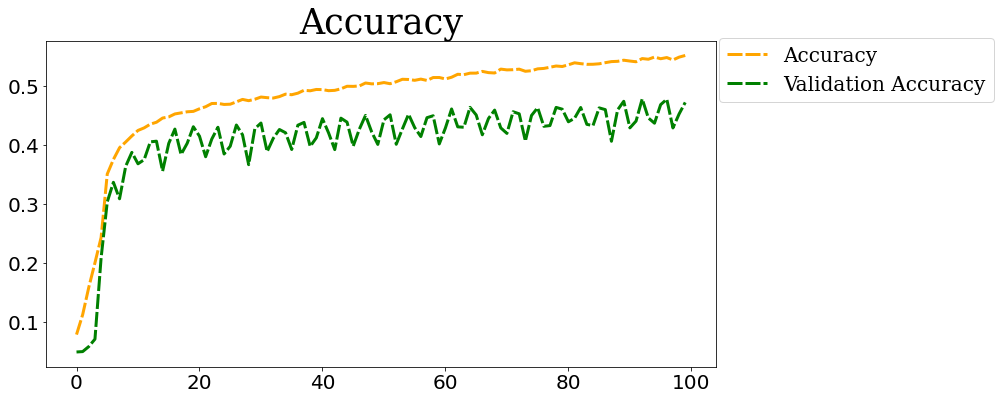

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Accuracy', fontsize=35, fontname = 'DejaVu Serif', fontweight = 500)
plt.plot(acc_unet, color='orange', linestyle='-.', dashes=(5, 1), linewidth=3.0)
plt.plot(val_acc_unet, color='green', linestyle='-.', dashes=(5, 1), linewidth=3.0)
# plt.plot(loss_t_domain_list, color='blue', linestyle='-.', dashes=(5, 1), linewidth=3.0)
# plt.plot(loss_list, color='red', linewidth=3.0)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(['AttnR2Unet','R2Unet','AttnUnet','MultiResUnet','Mod UNet','UNet', 'Proposed Attn 1'],loc="lower right")
lgd = plt.legend(['Accuracy', 'Validation Accuracy'],loc="lower right",
          prop={'family':'DejaVu Serif', 'size':20}, bbox_to_anchor=(1.43, 0.78))
plt.savefig('Accuracy.eps',  bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('Accuracy.png',  bbox_extra_artists=(lgd,), bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


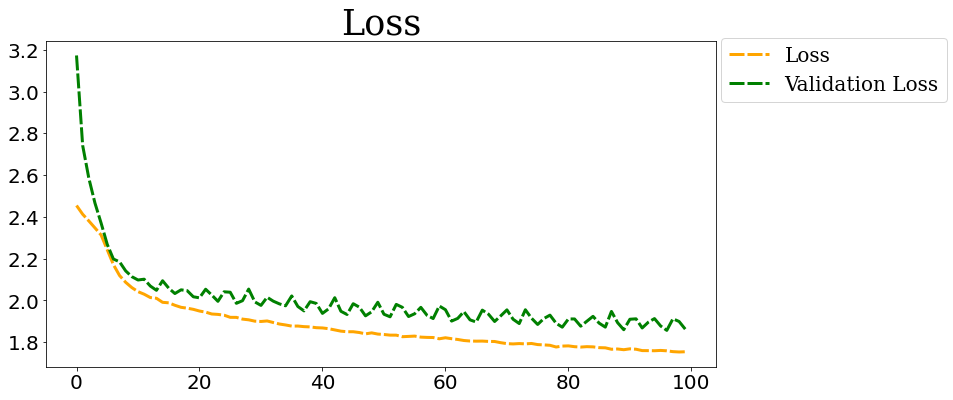

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Loss', fontsize=35, fontname = 'DejaVu Serif', fontweight = 500)
plt.plot(loss_unet, color='orange', linestyle='-.', dashes=(5, 1), linewidth=3.0)
plt.plot(val_loss_unet, color='green', linestyle='-.', dashes=(5, 1), linewidth=3.0)
# plt.plot(loss_t_domain_list, color='blue', linestyle='-.', dashes=(5, 1), linewidth=3.0)
# plt.plot(loss_list, color='red', linewidth=3.0)


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(['AttnR2Unet','R2Unet','AttnUnet','MultiResUnet','Mod UNet','UNet', 'Proposed Attn 1'],loc="lower right")
lgd = plt.legend(['Loss', 'Validation Loss'],loc="lower right",
          prop={'family':'DejaVu Serif', 'size':20}, bbox_to_anchor=(1.36, 0.78))

plt.savefig('Loss.eps',  bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('Loss.png',  bbox_extra_artists=(lgd,), bbox_inches='tight')

In [74]:
# predict.py

# import LoadBatches
from keras.models import load_model
# from Models import FCN32, FCN8, SegNet, UNet
import glob
import cv2
import numpy as np
import random

n_classes = 11

key = "unet"

# method = {
#     "fcn32": FCN32.FCN32,
#     "fcn8": FCN8.FCN8,
#     "segnet": SegNet.SegNet,
#     'unet': UNet.UNet}

images_path = "dataset1/images_prepped_test/"
segs_path = "dataset1/annotations_prepped_test/"

input_height = 320
input_width = 320

colors = [
    (random.randint(
        0, 255), random.randint(
            0, 255), random.randint(
                0, 255)) for _ in range(n_classes)]

##########################################################################


def label2color(colors, n_classes, seg):
    seg_color = np.zeros((seg.shape[0], seg.shape[1], 3))
    for c in range(n_classes):
        seg_color[:, :, 0] += ((seg == c) *
                               (colors[c][0])).astype('uint8')
        seg_color[:, :, 1] += ((seg == c) *
                               (colors[c][1])).astype('uint8')
        seg_color[:, :, 2] += ((seg == c) *
                               (colors[c][2])).astype('uint8')
    seg_color = seg_color.astype(np.uint8)
    return seg_color


def getcenteroffset(shape, input_height, input_width):
    short_edge = min(shape[:2])
    xx = int((shape[0] - short_edge) / 2)
    yy = int((shape[1] - short_edge) / 2)
    return xx, yy


images = sorted(
    glob.glob(
        images_path +
        "*.jpg") +
    glob.glob(
        images_path +
        "*.png") +
    glob.glob(
        images_path +
        "*.jpeg"))
segmentations = sorted(glob.glob(segs_path + "*.jpg") +
                       glob.glob(segs_path + "*.png") + glob.glob(segs_path + "*.jpeg"))


# m = load_model("output/%s_model.h5" % key)
m = UNet(11, 320, 320)  # 有自定义层时，不能直接加载模型
m.load_weights("output/%s_model.h5" % key)

count = 0

for i, (imgName, segName) in enumerate(zip(images, segmentations)):
    if i % 10 == 0:
        print("%d/%d %s" % (i + 1, len(images), imgName))

        im = cv2.imread(imgName, 1)
        # im=cv2.resize(im,(input_height,input_width))
        xx, yy = getcenteroffset(im.shape, input_height, input_width)
        im = im[xx:xx + input_height, yy:yy + input_width, :]

        seg = cv2.imread(segName, 0)
        # seg= cv2.resize(seg,interpolation=cv2.INTER_NEAREST)
        seg = seg[xx:xx + input_height, yy:yy + input_width]

        pr = m.predict(np.expand_dims(getImageArr(im), 0))[0]
        pr = pr.reshape((input_height, input_width, n_classes)).argmax(axis=2)

        plt.figure(figsize=(10,10))
        plt.subplot(1,3,1)
        plt.imshow(im)
        plt.title('Input')
        plt.subplot(1,3,2)
        plt.imshow(label2color(colors, n_classes, pr))
        plt.title('Prediction')
        plt.subplot(1,3,3)
        plt.imshow(label2color(colors, n_classes, seg))
        plt.title('Ground Truth')
        plt.savefig('results/'+str(i)+'.png',format='png')
        plt.close()
        
    

1/101 dataset1/images_prepped_test/0016E5_07959.png
11/101 dataset1/images_prepped_test/0016E5_07979.png
21/101 dataset1/images_prepped_test/0016E5_07999.png
31/101 dataset1/images_prepped_test/0016E5_08019.png
41/101 dataset1/images_prepped_test/0016E5_08039.png
51/101 dataset1/images_prepped_test/0016E5_08059.png
61/101 dataset1/images_prepped_test/0016E5_08079.png
71/101 dataset1/images_prepped_test/0016E5_08099.png
81/101 dataset1/images_prepped_test/0016E5_08119.png
91/101 dataset1/images_prepped_test/0016E5_08139.png
101/101 dataset1/images_prepped_test/0016E5_08159.png


In [75]:
! zip -qq -r results.zip results

In [ ]:
"""
plt.imshow(im)
plt.savefig('results/'+str(i)+'_img.png',format='png')
plt.close()
plt.imshow(label2color(colors, n_classes, pr))
plt.savefig('results/'+str(i)+'_pr.png',format='png')
plt.close()
plt.imshow(label2color(colors, n_classes, seg))
plt.savefig('results/'+str(i)+'_gt.png',format='png')
plt.close()
"""